# WordCount in PySpark

This is the canonical WordCount example, that is often used to start with MapReduce.

We will read a large text file (downloaded from the Gutenberg project), parse it and do some counting.

Let's first import the necessary modules and the Spark Context

In [11]:
import sys
from pyspark import SparkContext
import re

Check it we have the right context

In [1]:
sc

Now we can write our WordCount program. Remember:
Map works by applying a function to each element in the list.
flatMap works applying a function that returns a sequence for each element in the list, and flattering the results into the original list. 

In [12]:
def mapper(line):
    words = re.split("\W+", line)
    return [(w.lower(), 1) for w in words if w]

lines = sc.textFile("hdfs://localhost:8020/user/cloudera/books/Quijote.txt")

counts = lines.flatMap(mapper).reduceByKey(lambda a, b: a + b)

output = counts.collect()


Now let's inspect the output

In [4]:
for (word, count) in output[1:10]:
    print "%s: %i" % (word, count)

naranja: 1
escribe: 17
escriba: 4
deponer: 1
escribo: 1
escribi: 23
otro: 511
rompelle: 1
avispas: 1


Now, let's prepare the output to be plotted: we want to show the distribution of word frequency

In [5]:
sortedOutput = sorted(output, key = lambda x: -x[1])[:10]
sortedOutput

[(u'que', 20628),
 (u'de', 18217),
 (u'y', 18197),
 (u'a', 15627),
 (u'la', 10399),
 (u'en', 8251),
 (u'el', 8216),
 (u'se', 6970),
 (u'no', 6384),
 (u'los', 4755)]

Now we're ready to build our plot

Populating the interactive namespace from numpy and matplotlib


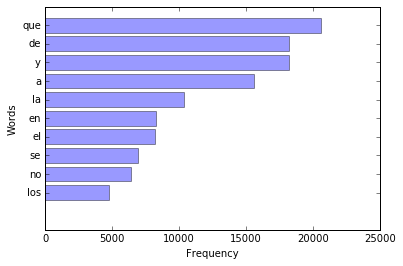

In [6]:
%pylab inline
import matplotlib.pyplot as plt

words = [w[0] for w in sortedOutput]
y_pos = range(len(sortedOutput))
frequency = [w[1] for w in sortedOutput]

plt.barh(y_pos, frequency[::-1], align='center', alpha=0.4)
plt.yticks(y_pos, words[::-1])
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.show()

And now let's stop the spark backend. VERY IMPORTANT!

In [7]:
sc.stop()

Ejercicio.

Repite la ejecución anterior pero:

1. Elimina las palabras que aparecen menos de 50 veces.
2. Elimina algunas stop-words (de, desde, a, ante, un, uno, una, unos...)

Posibles soluciones:

1. counts = lines.flatMap(mapper).reduceByKey(lambda a, b: a+b).filter(lambda x: x[1] >= 50)
2. Se plantea debajo...

In [13]:
# First define a list of uninteresting words, the stop words
stopwords = frozenset(['a','de','uno','el','no','se'])

# Broadcast this list to all worker processes in the cluster
stopwords_bc = sc.broadcast(stopwords)

# Create two accumulators for counting processed words
stopword_count = sc.accumulator(0)
regular_count = sc.accumulator(0)

# Define a filter function
def filter_word(w):
    # Check if a given word is in the list of stopwords
    if w in stopwords_bc.value:
        stopword_count.add(1)
        return False
    else:
        regular_count.add(1)
        return True

Read and process the file

In [14]:
text = sc.textFile('hdfs://localhost:8020/user/cloudera/books/Quijote.txt')
words = text.flatMap(lambda line: line.split(" ")) \
    .filter(filter_word) \
    .map(lambda word: (word,1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda x: x[1], ascending = False) 
    #.map(lambda (k,v): k + ':' + str(v))
# remember, HDFS does not overwrite with standard configuration
# QuijoteSalida is a directory
# words.saveAsTextFile('hdfs://localhost:8020/user/cloudera/books/QuijoteSalida')

Note from stackoverflow:

saveAsTextFile is really processed by Spark executors. Depending on your Spark setup, Spark executors may run as a different user than your Spark application driver. I guess the spark application driver prepares the directory for the job fine, but then the executors running as a different user have no rights to write in that directory.

Changing to 777 won't help, because permissions are not inherited by child dirs, so you'd get 755 anyways.

Try running your Spark application as the same user that runs your Spark.


In [18]:
# save as local file
words.saveAsTextFile('file:/home/cloudera/Code/Python/notebooks/QuijoteSalida')

Py4JJavaError: An error occurred while calling o655.saveAsTextFile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 30.0 failed 4 times, most recent failure: Lost task 0.3 in stage 30.0 (TID 76, quickstart.cloudera): java.io.IOException: Mkdirs failed to create file:/home/cloudera/Code/Python/notebooks/QuijoteSalida/_temporary/0/_temporary/attempt_201702151813_0030_m_000000_76 (exists=false, cwd=file:/yarn/nm/usercache/cloudera/appcache/application_1487176999350_0001/container_1487176999350_0001_01_000012)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:449)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:435)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:920)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:813)
	at org.apache.hadoop.mapred.TextOutputFormat.getRecordWriter(TextOutputFormat.java:123)
	at org.apache.spark.SparkHadoopWriter.open(SparkHadoopWriter.scala:91)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1$$anonfun$13.apply(PairRDDFunctions.scala:1193)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1$$anonfun$13.apply(PairRDDFunctions.scala:1185)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1843)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1856)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1933)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1213)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1060)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:951)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1457)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1436)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:316)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1436)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsTextFile(JavaRDDLike.scala:507)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:46)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:57)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:606)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.io.IOException: Mkdirs failed to create file:/home/cloudera/Code/Python/notebooks/QuijoteSalida/_temporary/0/_temporary/attempt_201702151813_0030_m_000000_76 (exists=false, cwd=file:/yarn/nm/usercache/cloudera/appcache/application_1487176999350_0001/container_1487176999350_0001_01_000012)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:449)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:435)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:920)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:813)
	at org.apache.hadoop.mapred.TextOutputFormat.getRecordWriter(TextOutputFormat.java:123)
	at org.apache.spark.SparkHadoopWriter.open(SparkHadoopWriter.scala:91)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1$$anonfun$13.apply(PairRDDFunctions.scala:1193)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1$$anonfun$13.apply(PairRDDFunctions.scala:1185)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1145)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:615)
	... 1 more


In [7]:
# Print processing metrics
print stopword_count.value
print regular_count.value

46111
347653


In [8]:
output = words.collect()
for (word, count) in output[1:10]:
    print "%s: %i" % (word, count)


y: 15894
la: 10200
: 9504
en: 7898
los: 4680
con: 4047
por: 3758
las: 3423
lo: 3387


Stop the context

In [19]:
sc.stop()